In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


In [2]:
import pandas as pd

### Useful functions

The `plot_ts` auxiliary function defined below will be useful to plot time series, and different models' forecasts.

In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

def plot_ts(df_train, df_test=None, model=None, level=None):
    fig, axes = plt.subplots(1, 1, figsize = (10, 5))

    uid = df_train['unique_id'].unique().item()
    train_uid = df_train.query('unique_id == @uid')
    axes.plot(train_uid['ds'], train_uid['y'], label = 'y_train')
    if df_test is not None:
        max_ds = train_uid['ds'].max()
        test_uid = df_test.query('unique_id == @uid')
        for col in ['y', f'{model}-median', 'y_test']:
            if col in test_uid:
                axes.plot(test_uid['ds'], test_uid[col], label=col)
        if level is not None:
            for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                axes.fill_between(
                    test_uid['ds'],
                    test_uid[f'{model}-lo-{l}'],
                    test_uid[f'{model}-hi-{l}'],
                    alpha=alpha,
                    color='green',
                    label=f'{model}_level_{l}',
                )
    axes.set_title(f'Time Series: {uid}')
    axes.set_xlabel('Timestamp [t]')
    # rotate x label ticks
    for tick in axes.get_xticklabels():
        tick.set_rotation(45)
    axes.set_ylabel('Target')
    axes.legend(loc='upper left')
    axes.xaxis.set_major_locator(plt.MaxNLocator(20))
    axes.grid()
    plt.show()

### Config

In [4]:
WINDOW = 12
HORIZON = 12

### Generating Synthetic Data

In [5]:
import numpy as np

# Define the non-linear trend function
def non_linear_trend(t):
    return 0.5 * t**1.5 + 0.2 * t + 0.1

# Define the seasonality function
def seasonality(t):
    return 50 * np.sin(2 * np.pi * t) + 10 * np.random.randn(len(t))

# Define the noise function
def noise(t):
    return 5 * np.random.randn(len(t))

# Sample regular time points
time_points = np.linspace(0, 100, 500)

# Create a TimeSeries object with the non-linear trend
samples = non_linear_trend(time_points) + seasonality(time_points) + noise(time_points)

# Comverting time into dates
time_points = pd.date_range(start='2020-01-01', periods=len(time_points), freq='D')
# Prepare the dataframe
df = pd.DataFrame({'unique_id':"A", 'ds': time_points, 'y': samples})

# Split into Train and Test
Y_test_df = df.groupby('unique_id').tail(HORIZON)
Y_train_df = df.drop(Y_test_df.index)

In [6]:
# from src.synthetic_ts.autoregressive import AutoRegressive
# import timesynth as ts


# def generate_timeseries(signal, noise=None):
#     time_sampler = ts.TimeSampler(stop_time=20)
#     regular_time_samples = time_sampler.sample_regular_time(num_points=500)
#     timeseries = ts.TimeSeries(signal_generator=signal, noise_generator=noise)
#     samples, signals, errors = timeseries.sample(regular_time_samples)
#     return samples, regular_time_samples, signals, errors

# #Generating Pseudo Periodic Signal
# pseudo_samples, regular_time_samples, _, _ = generate_timeseries(signal=ts.signals.PseudoPeriodic(amplitude=0.1, frequency=0.25), noise=ts.noise.GaussianNoise(std=0.1))
# # Generating an Autoregressive Signal
# ar_samples, regular_time_samples, _, _ = generate_timeseries(signal=AutoRegressive(ar_param=[0.2]))
# # Combining the two signals using a mathematical equation
# samples = ar_samples #pseudo_samples+
# # Comverting time into dates
# regular_time_samples = pd.date_range(start='2020-01-01', periods=len(regular_time_samples), freq='D')
# # Prepare the dataframe
# df = pd.DataFrame({'unique_id':"A", 'ds': regular_time_samples, 'y': samples})

# # Split into Train and Test
# Y_test_df = df.groupby('unique_id').tail(HORIZON)
# Y_train_df = df.drop(Y_test_df.index)

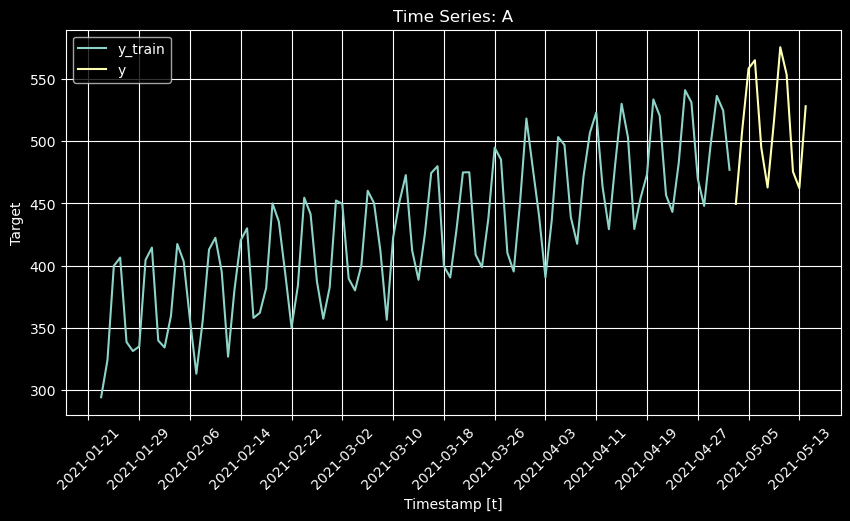

In [7]:
plot_ts(Y_train_df.tail(100), Y_test_df)

### Model Definition

In [8]:
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.losses.pytorch import MAE
import torch
import torch.nn as nn

from src.dl.nf_models import SeriesDecomp

#### Custom NeuralForecast Model

We can have a bit of fun and define a custom model (a tweak on the DLinear models we saw earlier) that uses a neural network to forecast the time series. The model will have the following architecture:
```
     Input----------------------
      |                         |
Series Decomposition            |
      /\                        |
     /  \                       |
Trend   Seasonality             |
  |            |                |
Trend      Seasonality    Non-Linear Trend
Predictor   Predictor       Predictor
      |         |           |
      ----------------------
              (Add)
                |
              Output  
  
```

And we will be overriding the `predict_step` method to include MC Dropout inference.

In [9]:
def enable_dropout(model):
    """Function to enable the dropout layers during test-time"""
    for m in model.modules():
        if m.__class__.__name__.startswith("Dropout"):
            m.train()


class MontecarloDropoutDNonLinear(BaseWindows):
    def __init__(
        self,
        # Inhereted hyperparameters with no defaults
        h,
        input_size,
        # Model specific hyperparameters
        moving_avg_window=3,
        dropout=0.1,
        # Inhereted hyperparameters with defaults
        exclude_insample_y=False,
        loss=MAE(),
        valid_loss=None,
        max_steps: int = 1000,
        learning_rate: float = 1e-3,
        num_lr_decays: int = -1,
        early_stop_patience_steps: int = -1,
        val_check_steps: int = 100,
        batch_size: int = 32,
        valid_batch_size: int = None,
        windows_batch_size=1024,
        inference_windows_batch_size=-1,
        start_padding_enabled: bool = False,
        step_size: int = 1,
        scaler_type: str = "identity",
        random_seed: int = 1,
        num_workers_loader: int = 0,
        drop_last_loader: bool = False,
        **trainer_kwargs,
    ):
        # Inherit BaseWindows class
        if moving_avg_window % 2 == 0:
            raise Exception("moving_avg_window should be uneven")
        super(MontecarloDropoutDNonLinear, self).__init__(
            h=h,
            input_size=input_size,
            exclude_insample_y=exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            num_lr_decays=num_lr_decays,
            learning_rate=learning_rate,
            early_stop_patience_steps=early_stop_patience_steps,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            num_workers_loader=num_workers_loader,
            **trainer_kwargs,
        )
        # Model specific hyperparameters
        self.moving_avg_window = moving_avg_window
        self.dropout = dropout

        self.decomp = SeriesDecomp(self.moving_avg_window)
        self.non_linear_block = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.input_size, 100),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(100, self.h),
        )
        self.linear_trend = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.input_size, self.h),
        )
        self.seasonal_trend = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.input_size, self.h),
        )

    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y = windows_batch[
            "insample_y"
        ].clone()  # --> (batch_size, input_size)
        seasonal_init, trend_init = self.decomp(
            insample_y
        )  # --> (batch_size, input_size)
        # Non-linear block
        non_linear_part = self.non_linear_block(
            insample_y
        )  # --> (batch_size, horizon)

        trend_part = self.linear_trend(trend_init)  # --> (batch_size, horizon)
        seasonal_part = self.seasonal_trend(
            seasonal_init
        )  # --> (batch_size, horizon)
        # Final
        forecast = (
            trend_part + seasonal_part + non_linear_part
        )  # --> (batch_size, horizon)
        forecast = self.loss.domain_map(forecast)
        return forecast

    def predict_step(self, batch, batch_idx):
        enable_dropout(self)
        pred_samples = []
        for i in range(self.num_samples):
            y_hat = super().predict_step(batch, batch_idx)
            pred_samples.append(y_hat)
        pred_samples = torch.stack(pred_samples, dim=0)
        y_hat = [pred_samples.quantile(0.5, dim=0)]
        if self.levels is not None:
            for l in self.levels:
                hi = l / 100.0
                lo = 1 - hi
                y_hat_lo = pred_samples.quantile(lo, dim=0)
                y_hat_hi = pred_samples.quantile(hi, dim=0)
                y_hat.extend([y_hat_lo, y_hat_hi])
        y_hat = torch.stack(y_hat, dim=-1)
        return y_hat

#### Custom Redefinition of the Neuralforecast class

In [10]:
from neuralforecast import NeuralForecast

In [11]:
class MCNeuralForecast(NeuralForecast):
    def __init__(self, num_samples, levels=None, **kwargs):
        super().__init__(**kwargs)
        self.num_samples = num_samples
        self.levels = levels

    def predict(
        self,
        df=None,
        static_df=None,
        futr_df=None,
        sort_df=True,
        verbose=False,
        engine=None,
        **data_kwargs,
    ):
        # Adding model columns to loss output names
        # Necessary hack to get the quantiles and format it correctly
        for model in self.models:
            model.loss.output_names = ["-median"]
            for l in list(self.levels):
                model.loss.output_names.append(f"-lo-{l}")
                model.loss.output_names.append(f"-hi-{l}")
            # Setting the number of samples and levels in the model
            model.num_samples = self.num_samples
            model.levels = self.levels
        return super().predict(
            df, static_df, futr_df, sort_df, verbose, engine, **data_kwargs
        )

### Model Training

In [12]:
levels = [80, 90]
model = MontecarloDropoutDNonLinear(
    h=HORIZON,
    input_size=WINDOW,
    moving_avg_window=3,
    dropout=0.1,
    max_steps=500,
    early_stop_patience_steps=5,
)

mcnf = MCNeuralForecast(models=[model], freq="D", num_samples=100, levels=levels)
mcnf.fit(Y_train_df, val_size=HORIZON, verbose=True)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type          | Params
---------------------------------------------------
0 | loss             | MAE           | 0     
1 | padder_train     | ConstantPad1d | 0     
2 | scaler           | TemporalNorm  | 0     
3 | decomp           | SeriesDecomp  | 0     
4 | non_linear_block | Sequential    | 12.6 K
5 | linear_trend     | Sequential    | 156   
6 | seasonal_trend   | Sequential    | 156   
---------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


In [13]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point rediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = mcnf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,MontecarloDropoutDNonLinear-median,MontecarloDropoutDNonLinear-lo-80,MontecarloDropoutDNonLinear-hi-80,MontecarloDropoutDNonLinear-lo-90,MontecarloDropoutDNonLinear-hi-90
0,A,2021-05-03,462.253967,426.180725,497.488892,393.958984,511.101227
1,A,2021-05-04,498.890137,445.501587,544.368042,415.558685,568.371948
2,A,2021-05-05,560.047852,524.554260,583.478516,509.338135,596.017883
3,A,2021-05-06,543.547668,510.240509,563.699463,501.584595,574.733093
4,A,2021-05-07,486.072662,445.962280,514.169617,421.435547,536.067993


In [14]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

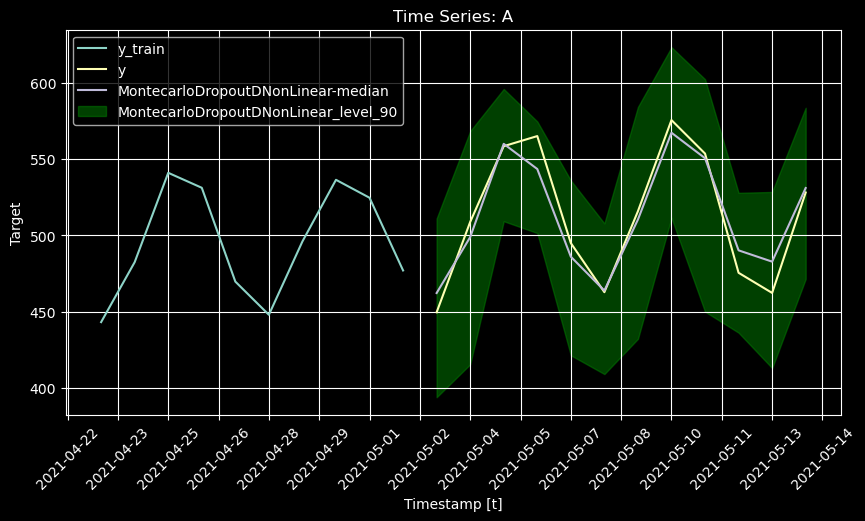

In [15]:
plot_ts(Y_train_df.tail(10), Y_test_df, model="MontecarloDropoutDNonLinear", level=[90])